In [1]:
!date

Fri Jun 11 10:56:25 MDT 2021


# Backward time loop to track coast-crossing vapor lakes (CCVLs)
### using Geopandas methods from Geopandas_overlaps.ipynb

------------


## each new assigned CCVL creates a folder called `tag/` 

### tag format is `yyyymmddhh_at_coast.meanlat`

where meanlat is the mean latitude of the overlap with a coastline or (simplest case) meridian. It contains a shapefile (with a time series of multipolygons), and perhaps the data columns only (much smaller, just the stats, for aggregating as a meta-dataset). 

In [2]:
from shapely import geometry
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import fiona             # a read-write library for shapefiles
import os         
#from descartes.patch import PolygonPatch

from glob import glob
import xarray as xr
#import dask.array as da

import pandas as pd
import geopandas as gp
from datetime import datetime

# A function to return a GeoDataFrame of polygons 

In [99]:
# loop over contour collections (and polygons in each collection)
# store in polylist  
def gdf_from_contours(lon,lat,tqv,conlevel):
    
    levels = [conlevel, 9e9]
    cs = plt.contourf(lon,lat,tqv,levels)
# create lookup table for levels
    lvl_lookup = dict(zip(cs.collections, cs.levels))
    
    zvalues, polylist  = [], []
#    i=0
    for col in cs.collections:
        z=lvl_lookup[col] # the value of this level
        for contour_path in col.get_paths():
#        print('contour path: ',i); i = i+1
        # create the polygon for this level
            for ncp,cp in enumerate(contour_path.to_polygons()):
#            print('   ncp: ', ncp)
                lons = np.array(cp)[:,0]
                lats = np.array(cp)[:,1]
                new_shape = geometry.Polygon([(i[0], i[1]) for i in zip(lons,lats)])            
                if ncp == 0:
                    poly = new_shape # first shape
                else:
                    poly = poly.difference(new_shape) # Remove the holes

            polylist.append(poly)
            zvalues.append(z)
        
        gdf = gp.GeoDataFrame(geometry=polylist)
        gdf['tqv_values']=zvalues
        gdf['area']=gdf.area
        gdf['maxlon']=gdf.bounds.maxx
        return(gdf)

<AxesSubplot:>

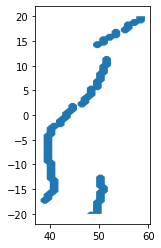

In [205]:
gdf_litt = gp.read_file('Africa_Ecoast_20NS.geojson')
gdf_litt.plot()

------------

# Open the virtual (time series) dataset in xarray

In [206]:
files = glob('MERRA2*.nc') #+glob('*2015*')+glob('*2016*')+glob('*2017*')+glob('*2018*') # selecting 2014-2018
cwv_data = xr.open_mfdataset(files) # merging data files in one
cwv_WEIO = cwv_data.sel(lat=slice(-30,30),lon=slice(30,90))

# To initialize the cycle, process the last-most time (index -1) to a gdf

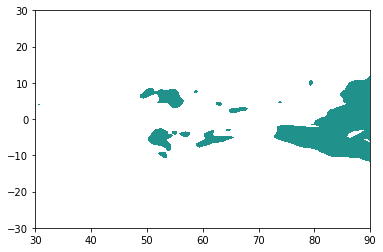

In [210]:
ccvls_stats = [] # empty, to collect the stats of ccvls

# dest means destined, the future time level in a reverse time loop
# Initially, it is the -1 element of the data, and we need a first coast-overlap test
gdf_dest = gdf_from_contours(cwv_WEIO.lon,cwv_WEIO.lat,cwv_WEIO.TQV[-1],55.)

# Make gdf_ccvls containing only the coast-overlappers

In [213]:
i_litt, i_dest = gdf_dest.sindex.query_bulk(gdf_litt.geometry, predicate='overlaps') 
# i_litt, i_dest # littoral is in 0,3 since there are 4 polygons in the littoral gdf

In [214]:
# XXXXXX DELETE ME FOr debug challenge, suppose i_dest = [2,3] with two elements
i_dest = [2,3,6]

In [233]:
# ccvls is a SUBSET: I only care about the ones that touch the coast
gdf_ccvls = gdf_dest.loc[i_dest]

# Must re-index in order for .loc[] to work later in overlap tests 
gdf_ccvls.index = range( len(gdf_ccvls.index) )
gdf_ccvls  

,geometry,tqv_values,area,maxlon
0,"POLYGON ((53.75000 -8.70070, 54.22038 -8.50000...",55.0,14.351828,54.518603
1,"POLYGON ((59.37500 -7.72917, 59.70920 -7.50000...",55.0,10.741246,65.496707
2,"POLYGON ((64.37500 -3.14660, 64.93152 -3.00000...",55.0,0.105836,64.931522


# Add data columns: time [-1], and tag (string with meanlat)
## tag is useful as a filename, and maybe as the name of a ccvl's gdf 

In [806]:
# Because a geometry may be tied to more then one CCVL, 
# I need the tags column of gdf_ccvls to be a *list* of strings, not a string. 
# So to assign it, I need a *list of lists* of strings to set it equal to.
# UPDATE: no need for this, overlap just makes duplicate of either the tag or the geometry

# time as numpy datetime object
yyyymmddhh = cwv_WEIO.time[-1].values
gdf_ccvls['time'] = yyyymmddhh 

# time as a string (have to parse through pandas, UGH!)
timestring = pd.to_datetime(str(yyyymmddhh)).strftime('%Y_%m_%d_%H')

# mean latitude as a string with N/S rather than dash for sign
centlats = gdf_ccvls.geometry.centroid.y
NS = ['N','S']

# list of `tag` strings with no - nor . characters, ready to add as a new data column
ccvltag = [  timestring+'_lat'+ str(abs(centlats[i]))[:5]   for i in range(len(centlats)) ] 
ccvltag = [ ccvltag[i] + NS[ int(centlats[i]<0) ]   for i in range(len(centlats)) ] 
ccvltag = [ ccvltag[i].replace('.','p') for i in range(len(ccvltag)) ]

gdf_ccvls['tag'] = ccvltag
gdf_ccvls

,geometry,tqv_values,area,maxlon,tag,time
0,"POLYGON ((53.75000 -8.72341, 54.37500 -8.97518...",55.0,16.212948,54.672109,2014_05_15_23_lat5p439S,2014-05-15 23:00:00
1,"POLYGON ((59.37500 -8.00691, 59.38292 -8.00000...",55.0,13.001484,66.236093,2014_05_15_23_lat5p423S,2014-05-15 23:00:00
2,"POLYGON ((64.37500 -3.14717, 65.00000 -3.12123...",55.0,0.331279,65.138163,2014_05_15_23_lat2p883S,2014-05-15 23:00:00
3,"POLYGON ((68.12500 1.30362, 68.24070 1.50000, ...",55.0,3.733042,68.458301,2014_05_15_23_lat2p394N,2014-05-15 23:00:00
4,"POLYGON ((31.25000 3.49991, 31.25013 3.50000, ...",55.0,0.011183,31.259966,2014_05_15_23_lat3p835N,2014-05-15 23:00:00
5,"POLYGON ((68.12500 1.30362, 68.24070 1.50000, ...",55.0,3.733042,68.458301,2014_05_15_23_lat2p394N,2014-05-15 23:00:00
6,"POLYGON ((31.25000 3.49991, 31.25013 3.50000, ...",55.0,0.011183,31.259966,2014_05_15_23_lat3p835N,2014-05-15 23:00:00
7,"POLYGON ((68.12500 1.30362, 68.24070 1.50000, ...",55.0,3.733042,68.458301,2014_05_15_23_lat2p394N,2014-05-15 23:00:00
8,"POLYGON ((31.25000 3.49991, 31.25013 3.50000, ...",55.0,0.011183,31.259966,2014_05_15_23_lat3p835N,2014-05-15 23:00:00


<AxesSubplot:>

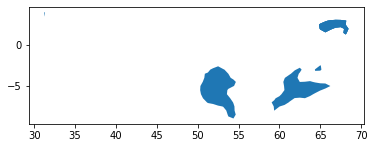

In [802]:
np.datetime64('1900-01-01')

numpy.datetime64('1900-01-01')

In [804]:
float(yyyymmddhh - np.datetime64('1900-01-01'))

3.6091836e+18

# Initialize a GDF for each CCVL
### so that shapes at other times can be appended, within the time loop 

In [515]:
# Clever trick exec() so the tag can be used as a variable name
## HUGE HEADACHE with append(), have to subset using two-index method to make it work
# ccvl_2014_05_15_23_lat5p382S = gdf_ccvls.iloc[0:1]
#    ready for ccvl_2014_05_15_23_lat5p382S.append(ccvl_2014_05_15_23_lat5p577S)
#    del(variable) is how you remove it from memory

for i in range(len(gdf_ccvls)):
    command = 'ccvl_' + gdf_ccvls.iloc[i].tag + ' = gdf_ccvls.iloc[' +str(i)+':'+str(i+1)+']'
    #print(command)
    exec(command) # creates new gdf for each tag, ready to append 

----------
# Time loop over hours, backward in time


In [225]:
for i in range( len(cwv_WEIO.time)-2 ):
    iback = -(i+2)
    # print('time level is ', iback) confirms this goes -2, -3, -4, ... 

    
    iback = -2 # for testing; remove to free up the loop 


# Discussion of backward time loop action steps 
We need to be 

1. Checking the overlap of *new* and *ccvl* shapes
1. Transferring CCVL tag to any (all) overlapper shapes, discarding non-overlappers
1. Appending all non-megalake overlappers to a GDF for each CCVL, ready to write out
1. Testing for CCVL birth (present in dest, absent in now). Write terminated CCVLs as .geojson, and append their duration, areatime, bounds and other stats to a big Pandas df meta-index of all CCVLs
1. Find new coast-crossers now, spawn as new CCVLs IFF they don't exist yet
1. Transfer gdf_ccvls_now to gdf_ccvls for next iteration

One tricky question is where and how to build up a GDF for each CCVL. Sub-questions include how to spawn & name these CCVL GDFs, how to append, and how to retire them after writeout for memory savings. 

## Step 1 in loop: check overlap of CCVLs and now-shapes

numpy.datetime64('2014-05-15T22:00:00.000000000')

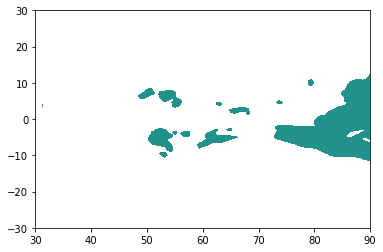

In [415]:
    gdf_now = gdf_from_contours(cwv_WEIO.lon,cwv_WEIO.lat,cwv_WEIO.TQV[iback],55.)
    cwv_WEIO.time[iback].values # print now time, for debugging

### Step 1 basic plots for debugging: red is now, blue is dest

<AxesSubplot:>

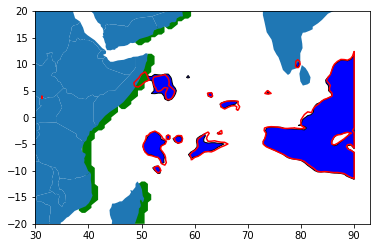

In [416]:
    #https://geopandas.org/docs/user_guide/mapping.html
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_xlim(30, 93)
    ax.set_ylim(-20,20)

    gdf_dest.plot(ax=ax,color='blue', edgecolor='black')
    gdf_now.boundary.plot(ax=ax, color='red')
    gdf_litt.plot(ax=ax, color='green')

    path = gp.datasets.get_path('naturalearth_lowres')
    mapdf = gp.read_file(path)
    mapdf.plot(ax=ax)

### Still step 1: find overlaps

In [417]:
    i_ccvls, i_now = gdf_now[(gdf_now.area>0)].sindex.query_bulk(gdf_ccvls.geometry, predicate='overlaps') # index numbers of overlaps
    i_ccvls, i_now

(array([0, 1, 2]), array([2, 3, 6]))

In [418]:
    gdf_now.loc[i_now] # debug

,geometry,tqv_values,area,maxlon
2,"POLYGON ((53.75000 -8.72341, 54.37500 -8.97518...",55.0,16.212948,54.672109
3,"POLYGON ((59.37500 -8.00691, 59.38292 -8.00000...",55.0,13.001484,66.236093
6,"POLYGON ((64.37500 -3.14717, 65.00000 -3.12123...",55.0,0.331279,65.138163


In [512]:
    gdf_ccvls.loc[i_ccvls] # debug

,geometry,tqv_values,area,maxlon,time,tag
0,"POLYGON ((53.75000 -8.70070, 54.22038 -8.50000...",55.0,14.351828,54.518603,2014-05-15 23:00:00,2014_05_15_23_lat5p382S
0,"POLYGON ((53.75000 -8.70070, 54.22038 -8.50000...",55.0,14.351828,54.518603,2014-05-15 23:00:00,2014_05_15_23_lat5p382S
0,"POLYGON ((53.75000 -8.70070, 54.22038 -8.50000...",55.0,14.351828,54.518603,2014-05-15 23:00:00,2014_05_15_23_lat5p382S


## Step 2 in loop: copy overlappers into gdf_ccvls_now, copy tag, add time 

In [790]:
    # Assign a new gdf: gdf_ccvls_now, all now objects that are part of a ccvl
    gdf_ccvls_now = gdf_now.loc[i_now]
    
    # Port the tags from ccvls to ccvls_now 
    gdf_ccvls_now['tag'] = gdf_ccvls.iloc[i_ccvls].tag.values
    gdf_ccvls_now['time'] = cwv_WEIO.time[iback].values

    # Only keep ones that aren't megalake (maxlon < 89)
    gdf_ccvls_now = gdf_ccvls_now[gdf_ccvls_now.maxlon<89]
    
    gdf_ccvls_now

,geometry,tqv_values,area,maxlon,tag,time
11,"POLYGON ((73.75000 4.35056, 74.36850 4.50000, ...",55.0,0.419593,74.368501,2014_05_15_23_lat5p382S,2014-05-15 22:00:00
12,"POLYGON ((48.75000 5.82258, 49.37500 5.68906, ...",55.0,4.084929,51.459448,2014_05_15_23_lat5p382S,2014-05-15 22:00:00
13,"POLYGON ((79.37500 9.29312, 79.61756 9.50000, ...",55.0,0.962592,79.835570,2014_05_15_23_lat5p382S,2014-05-15 22:00:00


## Step 3 in loop: Append all ccvl_now to the existing GDF for each CCVL
#### ready to write out as a file. 
Appending to a copy is probably inefficient, but hey it works 

In [785]:
    for i in range(len(gdf_ccvls_now)):
        command = 'ccvl_' + gdf_ccvls.iloc[i].tag + ' = ' + \
                  'ccvl_' + gdf_ccvls.iloc[i].tag + \
                  '.append(gdf_ccvls_now.iloc[' +str(i)+':'+str(i+1)+'])'
        print(command)
        exec(command) # creates new gdf for each tag, ready to append 

ccvl_2014_05_15_23_lat5p382S = ccvl_2014_05_15_23_lat5p382S.append(gdf_ccvls_now.iloc[0:1])
ccvl_2014_05_15_23_lat5p382S = ccvl_2014_05_15_23_lat5p382S.append(gdf_ccvls_now.iloc[1:2])
ccvl_2014_05_15_23_lat5p382S = ccvl_2014_05_15_23_lat5p382S.append(gdf_ccvls_now.iloc[2:3])


----------------
## Step 4: test to terminate tracking of any destined ccvls that don't exist now
1. objects in ccvls that have no match now (borns)
1. objects now with maxlon>90 (cutoffs from EIO Meghalake) - HANDLED IN STEP2


In [791]:
## TEST DEBUG to create orphans 
i_ccvls=[0,0,0] # and then run from Step2 
#gdf_ccvls_now
# Must re-index in order for .loc[] to work later in overlap tests 
gdf_ccvls.index = range( len(gdf_ccvls.index) )

In [792]:
        # Find the orphans, write and perhaps delete from memory
        orphan_tags = pd.concat( [gdf_ccvls_now.tag, gdf_ccvls.tag] ).drop_duplicates(keep=False)

        for i in range(len(orphan_tags)):
            # WRITE OUT CCVL
            command = 'ccvl_' + str(orphan_tags.iloc[i]) + \
                      '.to_file("' + str(orphan_tags.iloc[i]) + \
                      '.geojson", driver="GeoJSON")'
            print('orphan, terminate. command: ', command)
            exec(command)
            
            # GATHER STATS ccvl_stats, APPEND TO GROWING META-INDEX OF CCVLs, use dummy copy
            command2 = 'dummy = ccvl_' + str(orphan_tags.iloc[i]) + '.copy()'
            print('command2: ', command2)
            exec(command2)
 
            #ccvl_stats
            areatime = dummy['area'].sum()
            maxarea = dummy['area'].max()
            duration = dummy['time'].max() - dummy['time'].min()
            tqv_values = dummy['tqv_values'].mean()
            lasttime = dummy['time'].max()
            ccvl_stats = pd.DataFrame(
                {
                 "lasttime": [lasttime],
                 "duration": [duration],
                 "areatime": [areatime],
                 "tqv_values": [tqv_values],
                 "maxarea": [maxarea]
                } )
            if(len(ccvls_stats)<1): ccvls_stats = ccvl_stats
            else: ccvls_stats = ccvls_stats.append(ccvl_stats)

            # DELETE FROM MEMORY in long loops 
            command3 = 'del(ccvl_' + str(orphan_tags.iloc[i]) + ')'
            print('command3: ', command3)
            exec(command3)                       

In [813]:
            command = 'dummy = ccvl_' + str(gdf_ccvls_now.iloc[0]) + '.copy()'
            command

'dummy = ccvl_geometry      POLYGON ((73.75 4.350563407744337, 74.36850145...\ntqv_values                                                 55.0\narea                                                   0.419593\nmaxlon                                                74.368501\ntag                                     2014_05_15_23_lat5p382S\ntime                                        2014-05-15 22:00:00\nName: 11, dtype: object.copy()'

In [812]:
# Test written-out file
tgf = gp.read_file("2014_05_15_23_lat2p998S.geojson")
tgf
tgf.plot(column='time', alpha=0.3)

DriverError: 2014_05_15_23_lat2p998S.geojson: No such file or directory

## Step 5: Find new coast-crossers now (now_cc). 
### Spawn as new CCVLs, IFF they don't exist in i_now


In [611]:
        i_litt, i_now_cc = gdf_now.sindex.query_bulk(gdf_litt.geometry, predicate='overlaps') 
        i_litt, i_now_cc # littoral is in 0,3 since there are 4 polygons in the littoral gdf

(array([2]), array([12]))

In [612]:
i_now # these were the ones already part of a CCVL

[11, 12, 13]

In [613]:
i_now_cc

array([12])

In [711]:
# DEBUG: make this a pseudo new ones
i_now_cc = [7,8]

In [701]:
        for i in i_now_cc: 
            print(i)
            if not (i in i_now): 
                print('adding new ccvl ', i)
                gdf_newccvl = gdf_now.iloc[i].copy()
                
                # add time
                timenow = cwv_WEIO.time[iback].values
                gdf_newccvl['time'] = timenow
                
                # add tag = timestring + str(meanlat)
                timestring = pd.to_datetime(str(timenow)).strftime('%Y_%m_%d_%H')
                centlat = gdf_newccvl.geometry.centroid.y
                ccvltag = timestring+'_lat'+ str(abs(centlat))[:5]
                ccvltag = ccvltag + NS[ int(centlat<0) ] 
                ccvltag = ccvltag.replace('.','p') 
                gdf_newccvl['tag'] = ccvltag

                # append to ccvls_now
                gdf_ccvls_now = gdf_ccvls_now.append(gdf_newccvl)
                
                # create the corresponding gdf_ccvl for this new ccvl
                # in transposed form ready to append to later
                command = 'ccvl_' + gdf_newccvl.tag + ' = gdf_newccvl.to_frame().T' 
                print(command)
                exec(command) # creates new gdf

7
adding new ccvl  7
ccvl_2014_05_15_22_lat2p394N = gdf_newccvl.to_frame().T
8
adding new ccvl  8
ccvl_2014_05_15_22_lat3p835N = gdf_newccvl.to_frame().T


In [704]:
        gdf_ccvls_now

,geometry,tqv_values,area,maxlon,tag,time
2,"POLYGON ((53.75000 -8.72341, 54.37500 -8.97518...",55.0,16.212948,54.672109,2014_05_15_23_lat5p382S,2014-05-15 22:00:00
3,"POLYGON ((59.37500 -8.00691, 59.38292 -8.00000...",55.0,13.001484,66.236093,2014_05_15_23_lat5p382S,2014-05-15 22:00:00
6,"POLYGON ((64.37500 -3.14717, 65.00000 -3.12123...",55.0,0.331279,65.138163,2014_05_15_23_lat5p382S,2014-05-15 22:00:00
7,"POLYGON ((68.12500 1.30362, 68.24070 1.50000, ...",55.0,3.733042,68.458301,2014_05_15_22_lat2p394N,2014-05-15 22:00:00
8,"POLYGON ((31.25000 3.49991, 31.25013 3.50000, ...",55.0,0.011183,31.259966,2014_05_15_22_lat3p835N,2014-05-15 22:00:00
7,"POLYGON ((68.12500 1.30362, 68.24070 1.50000, ...",55.0,3.733042,68.458301,2014_05_15_22_lat2p394N,2014-05-15 22:00:00
8,"POLYGON ((31.25000 3.49991, 31.25013 3.50000, ...",55.0,0.011183,31.259966,2014_05_15_22_lat3p835N,2014-05-15 22:00:00
7,"POLYGON ((68.12500 1.30362, 68.24070 1.50000, ...",55.0,3.733042,68.458301,2014_05_15_22_lat2p394N,2014-05-15 22:00:00
8,"POLYGON ((31.25000 3.49991, 31.25013 3.50000, ...",55.0,0.011183,31.259966,2014_05_15_22_lat3p835N,2014-05-15 22:00:00


## Step 6: Transfer gdf_ccvls_now to gdf_ccvls for next iteration, re-indexing

In [708]:
        gdf_ccvls = gdf_ccvls_now
        # Must re-index in order for .loc[] to work later in overlap tests 
        gdf_ccvls.index = range( len(gdf_ccvls.index) )

In [710]:
        gdf_ccvls

,geometry,tqv_values,area,maxlon,tag,time
0,"POLYGON ((53.75000 -8.72341, 54.37500 -8.97518...",55.0,16.212948,54.672109,2014_05_15_23_lat5p382S,2014-05-15 22:00:00
1,"POLYGON ((59.37500 -8.00691, 59.38292 -8.00000...",55.0,13.001484,66.236093,2014_05_15_23_lat5p382S,2014-05-15 22:00:00
2,"POLYGON ((64.37500 -3.14717, 65.00000 -3.12123...",55.0,0.331279,65.138163,2014_05_15_23_lat5p382S,2014-05-15 22:00:00
3,"POLYGON ((68.12500 1.30362, 68.24070 1.50000, ...",55.0,3.733042,68.458301,2014_05_15_22_lat2p394N,2014-05-15 22:00:00
4,"POLYGON ((31.25000 3.49991, 31.25013 3.50000, ...",55.0,0.011183,31.259966,2014_05_15_22_lat3p835N,2014-05-15 22:00:00
5,"POLYGON ((68.12500 1.30362, 68.24070 1.50000, ...",55.0,3.733042,68.458301,2014_05_15_22_lat2p394N,2014-05-15 22:00:00
6,"POLYGON ((31.25000 3.49991, 31.25013 3.50000, ...",55.0,0.011183,31.259966,2014_05_15_22_lat3p835N,2014-05-15 22:00:00
7,"POLYGON ((68.12500 1.30362, 68.24070 1.50000, ...",55.0,3.733042,68.458301,2014_05_15_22_lat2p394N,2014-05-15 22:00:00
8,"POLYGON ((31.25000 3.49991, 31.25013 3.50000, ...",55.0,0.011183,31.259966,2014_05_15_22_lat3p835N,2014-05-15 22:00:00


## For each polygon in the "now" array, CWV_now: 

A **polygon** is a domain-enclosed patch which may contain holes. The Polygon constructor takes two positional parameters. The first is an ordered sequence of (x, y[, z]) point tuples. The second is an optional unordered sequence of ring-like sequences specifying the interior boundaries or “holes” of the feature. Rings of a valid Polygon may not cross each other, but may touch at a single point only.

In [ ]:
    CWV_now = read(data)
    
# Need a function called **segment** that returns all the segments, and their maximum longitude (perhaps other properties too)
    cs = plt.contour(lon, lat, CWV_now, [55.])
    polygons = geometrize(cs)
    
# "inbounds" = just the ones not touching the edge of the domain   
    inbounds_polygons_now = polygons.where(convex_hull.lon.max() lt 100)

# Put them in a GeoPandas frame as the geometry column
    GeoFramePresent = gp.GeoSeries(inbounds_polygons_now)

## Memory items available: 

In working memory within the loop are always 3 [GeoPandas dataframes](https://geopandas.org/getting_started/introduction.html): 

0. GPdf_coast with the polygons of coastline, df_coast, no data columns 
1. GPdf_destined with the polygons of destiny (future in time, prior in backward time loop) 
2. GPdf_now with the polygons of the present

The geometry column contains all the holey polygons where CWV>55. The data columns are the tags of the active LLVLs, of which each holey polygon is a part. A holey polygon can be tagged as part of multiple CCVLs (notnull entry in multiple data columns), because physically it may be destined to split into parts that can each cross the coast. The data columns probably have a lot of empty or null entries, polygons that are never destined to cross the coast. 

![geopandas dataframe tableau](https://geopandas.org/_images/dataframe.svg "GeoPandas dataframe schema")

# Loop over the active CCVLs 
(the rows in GPdf_destined with at least one non-null data column entry) 

In [ ]:
# "All pandas DataFrame methods are also available, although they may not operate in a meaningful way on the geometry column.
    in_active_CCVLs = Gdf_destined.notnull().any(axis=1)
    
# For *EACH* of the polygons that is in any activeCCVL, test the overlap with *ALL* the GPdf_now.GeoSeries polygons

    for polygon in in_active_CCVLs.GeoColumn
        indices_1, indices_0 = CCVL.sindex.query_bulk(GPdf_0.GeoSeries, predicate='overlaps')
        overlapping = numpy.unique(indices_0)  # integer indeces of overlapping



In [ ]:
# "All pandas DataFrame methods are also available, although they may not operate in a meaningful way on the geometry column.
# For *ALL* of the polygons that is in any activeCCVL, test the overlap with *ALL* the GPdf_now.GeoSeries polygons

    indices_destined, indices_now = Gdf_destined.notnull().any(axis=1).sindex.query_bulk(GPdf_0.GeoSeries, predicate='overlaps')

# Add data columns in Gfd_now which are identical with the data columns in Gdf_destined
    Gdf_now[indices_now] = Gdf_destined[indices_destined]
    
# But now we will have to rejigger the dataframe to assemble the CCVLs from all their parts. Hmm. 


## OK, we have iterates seg0, and seg1
### Do they overlap? 
### If so, then CCVL_next contains seg0

In [ ]:
# from https://shapely.readthedocs.io/en/stable/manual.html
# object.overlaps(other)
# Returns True if the geometries have more than one but not all points in common, have the same dimension, and the intersection of the interiors of the geometries has the same dimension as the geometries themselves.

# Or, "If you want to check if the polygon overlaps with any other, you should check for that using geopandas spatial indexing capability."
# " # https://geopandas.org/getting_started/introduction.html#Geometry-relations
# https://geopandas.org/docs/reference/api/geopandas.sindex.SpatialIndex.query_bulk.html

input_indices, result_indices = shapes.sindex.query_bulk(shapes.geometry, predicate='overlaps')
overlapping = numpy.unique(result_indices)  # integer indeces of overlapping


# Faster is PyGEOS: 
# https://pygeos.readthedocs.io/en/latest/
#
# from_shapely(geometry, **kwargs) # Creates geometries from shapely Geometry objects.
# prepare(geometry, **kwargs)      # Prepare a geometry, improving performance of other operations.
#overlaps(a, b, **kwargs) #Returns True if A and B spatially overlap.
#Compute the area of all possible intersections of two lists of polygons:
#>>> area(intersection(polygons_x[:, np.newaxis], polygons_y[np.newaxis, :]))
#array([[100.,  90.,  80.,  70.,  60.],
#     [ 90.,  81.,  72.,  63.,  54.], ...
# geometrycollections(geometries, indices=None, **kwargs)
    

In [ ]:
                if overlap(seg1, seg0):
                    # consequence 1: this CCVL remains active (so CCVLkey belongs in the CCVL_new dictionary for next time iteration)
                    # that dictionary's value is a list of segments within CWV0, so syntax (perhaps illegal) is:
                    CCVL_new.update( {CCVLkey : append(seg0)} )  
                    
                    # consequence 2: seg0 is not eligible to pioneer a new CCVL. Need to mark it somehow. 
                    segflags[iseg] = True

-------------
----------------
## Strategize the desired outputs, so we can write results as they are obtained:

----------------
## The use of the output will be to 

    * screen whole-lifetime CCVL events based on lines in `CClakes.txt`
    * For selected events, further screen the hourly objects, based on lines in `tag/tag.times.txt`
    * Visualize lakes at selected times by placing shapefile contours on a geographical map, perhaps color-coded by time or by tag
-----------------
-----------------

### Therefore, at this step, we need to append seg0 as a shape in `tag/shapefiles/yymmddhh.contours`
### and also tally up seg0's contribution to the bulk statistics of CCVLkey at this time zero 



In [ ]:
                    contour_append(tag + '/shapefiles/' + yymmddhh + '.contours', seg0)  
                    update_1timetagstats( tagstats, seg0 ) # nsegs, npixels, kgwater, max/min lat/lon

#### End of loop over all seg0, and all seg1 for a given CCVL. If tagstats_t0[0] is still its initialization of zero, the CCVL quietly ends. 

In [ ]:

                # end for seg0 in ibounds            
            # end for seg1 in CCVLlist
            if (tagstats_t0[0] > 0): 
                append_1timetagstats(tagstats, tag+'/'+yymmhhdd+'.txt')

# what if some seg0 overlaps the coast, and not any previous seg0? 
# A new CCVL! 

In [ ]:
for iseg, seg0 in enumerate(inbounds, start=0): 
    if( does_overlap(coastline, seg0) and segflags[iseg] == False):
        
# Create a new 'tag' based on time and the latitude of the coast-crossing segment
        lala = meanlat_of_overlap(coastline,seg0)
        newtag = yymmddhh + '_' + str(lala)
        CCVL_new.update( {CCVLkey : append(seg0)} )  


### end of time zero (t0). Close the time loop and iterate. 

In [ ]:
# end for time in reverse(alltimes): 
# Overwrite the dictionary of active CCVLs for the next iteration 
CCVLs_active = CCVLs_new
# END CODE: ITERATION BACKWARD OVER TIME NOW REPEATS

-----------------
-----------------
-----------------

# a SEPARATE code can then glob over all the tag/yymmhhdd.txt files and construct `CClakes.txt`
## with one line per tag, comprising the stats over the whole lifetime of each CCVL
### summing up start and end date, lifetime in hours, total (area x hours), total (vapor x hours), bounding box (convex hull), centroid, etc. etc. 

#### All times (and thus tags and filenames) are based on the time of *last* contact with the coastline (first encountered, in the reverse-time flow of the algorithm's time loop). 

In [ ]:
# GeoPandas 
# https://geopandas.org/getting_started/introduction.html#Geometry-relations

# convex hull 

# gdf["convex_hull"] = gdf.convex_hull

# Open the data file of all time slices 

In [6]:
!ls -atlh /data2/brian/WEIO_30-100_20S-20N_2014-8.nc

-rw-rw-r-- 1 bmapes bmapes 755M Mar 10 18:55 /data2/brian/WEIO_30-100_20S-20N_2014-8.nc


In [7]:
TQV_WEIO = xr.open_dataset('/data2/brian/WEIO_30-100_20S-20N_2014-8.nc')
TQV_WEIO

<xarray.Dataset>
Dimensions:  (lat: 81, lon: 113, time: 43824)
Coordinates:
  * lat      (lat) float64 -20.0 -19.5 -19.0 -18.5 -18.0 ... 18.5 19.0 19.5 20.0
  * lon      (lon) float64 30.0 30.62 31.25 31.88 ... 98.12 98.75 99.38 100.0
  * time     (time) datetime64[ns] 2014-01-01 ... 2018-12-31T23:00:00
Data variables:
    TQV      (time, lat, lon) float32 ...

In [4]:
# playing with dictionaries for syntax test 
str1 = '2020030123'
str2 = 'dog'

dict = {}
dict.update({0.34 : str2})

dict
# print(dict[str1])


{0.34: 'dog'}